## Применение неявных методов в решении жесткой системы дифференциальных уравнений.

##### Задание X.9.5

In [106]:
import numpy as np
import matplotlib.pyplot as plt

#### Электрофизиология. Уравнение Бонгоффера-Ван-дер-Поля

$$
\begin{cases}
y_1' = a \left(- \left(\frac{y_1^3}{3} - y_1 \right) + y_2 \right) \\
y_2' = -y_1 - b y_2 + c
\end{cases}
$$

$$y_1(0) = 2, ~~~ y_2(0) = 0$$

В этом уравнении рассматриваются $a = 10^3$ и $a = 10^6$. Коэффициенты $c, b$ таковы, что $0 < c < 1$, $b > 0$.

In [107]:
A = 1e3
C = 0.5
B = 1
y01 = 2
y02 = 0

def foo_1(y1, y2):
    return A * (-(y1 ** 3 / 3 - y1) + y2)

def foo_2(y1, y2):
    return -y1 -B * y2 + C

def Foo(y):
    y1 = y[0]
    y2 = y[1]
    return np.array([
        foo_1(y1, y2),
        foo_2(y1, y2)
    ])

Применим трёхстадийный метод Розенброка

Cогласно теории, при решении жесткой системы ДУ методом Розенброка каждое следующее значение функции на сетке
вычисляется по следующей формуле

$$y_{n+1} = y_n + p_1 k_1 + p_2 k_2 + p_3 k_3$$

In [108]:
a  = 0.435866521508459
p1 = 0.435866521508459
p2 = 0.4782408332745185
p3 = 0.0858926452170225 
beta21 = 0.435866521508459
beta31 = 0.435866521508459
beta32 = -2.116053335949811

In [109]:
def Jacob(yn, h):
    y1n = yn[0]
    y2n = yn[1]

    df1dx1 = (foo_1(y1n + h, y2n) - foo_1(y1n - h, y2n)) / (2 * h)
    df1dx2 = (foo_1(y1n, y2n + h) - foo_1(y1n, y2n - h)) / (2 * h)
    df2dx1 = (foo_2(y1n + h, y2n) - foo_2(y1n - h, y2n)) / (2 * h)
    df2dx2 = (foo_2(y1n, y2n + h) - foo_2(y1n, y2n - h)) / (2 * h)

    res = np.array([
        [df1dx1, df1dx2],
        [df2dx1, df2dx2]
    ])
    return res

def diff_operator(yn, h):
    E = np.eye(2)
    return E + a * h * Jacob(yn, h / 10)

class Slae:
    def __init__(self, matrix: np.ndarray, values: np.ndarray):
        self.A = matrix
        self.f = values
    @property
    def dimention(self):
        return self.A.shape[0]

    def Gauss_mthd(self):
        A = self.A.astype(float, copy=True)
        f = self.f.astype(float, copy=True)
        N = self.dimention

        for k in range(N):
            for m in range(k+1, N):

                alpha = A[m][k] / A[k][k]

                f[m] = f[m] - f[k] * alpha 
                for i in range(k, N):
                    A[m][i] = A[m][i] - A[k][i] * alpha

        solution = np.full((N, ), 0.0)
        
        solution[N-1] = f[N - 1] / A[N - 1][N - 1]

        for k in range(N - 2, 0 - 1, -1):
            solution[k] = 1 / A[k][k] * (f[k] - np.dot(A[k], solution))

        return solution
    
def rozenbrok(f, h, t_start, t_end, initial_solution: tuple):
    t = np.linspace(t_start, t_end, int((t_end-t_start)/h+1))
    solution = np.zeros((int((t_end-t_start)/h+1), 2))
    solution[0] = initial_solution
    
    for i in range(len(t)-1):
        slae1 = Slae(diff_operator(solution[i], h), h * f(solution[i]))
        k1 = slae1.Gauss_mthd()
        slae2 = Slae(diff_operator(solution[i], h), h * f(solution[i] + beta21 * k1))
        k2 = slae2.Gauss_mthd()
        slae3 = Slae(diff_operator(solution[i], h), h * f(solution[i] + beta31 * k1 + beta32 * k2))
        k3 = slae3.Gauss_mthd()
        solution[i+1] = solution[i] + p1 * k1 + p2 * k2 + p3 * k3
    return solution

In [110]:
h = 0.0001
init_sol = np.array([2, 0])
t_start = 0
t_end = 100

sol = rozenbrok(Foo, h, t_start, t_end, init_sol)
y1_comp, y2_comp = sol.T
t = np.linspace(t_start, t_end, int((t_end-t_start)/h+1))

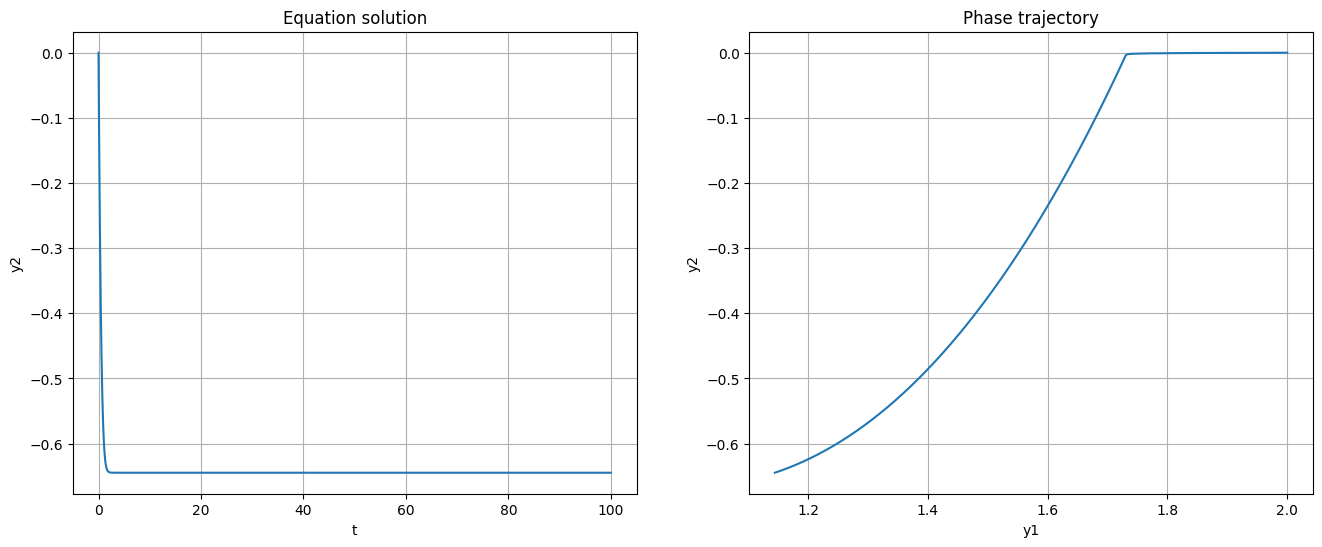

In [111]:
fig = plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(t, y2_comp)
plt.title('Equation solution')
plt.xlabel('t')
plt.ylabel('y2')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(y1_comp, y2_comp)
plt.title('Phase trajectory')
plt.xlabel('y1')
plt.ylabel('y2')
plt.grid()